In [1]:
import tensorflow as tf, os, random, shutil, zipfile, pathlib
print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Upload your kaggle.json (Kaggle > Account > Create New API Token)
from google.colab import files
uploaded = files.upload()

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset -p /content/data

zip_path = "/content/data/microsoft-catsvsdogs-dataset.zip"
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/content/data")

# Detect PetImages folder across common archive layouts
candidates = [
    "/content/data/PetImages",
    "/content/data/microsoft_cats_vs_dogs/PetImages",
    "/content/data/kagglecatsanddogs_3367a/PetImages",
]
pet_dir = None
for c in candidates:
    if os.path.isdir(c) and os.path.isdir(os.path.join(c, "Cat")) and os.path.isdir(os.path.join(c, "Dog")):
        pet_dir = c
        break

assert pet_dir, f"Could not find PetImages in {candidates}"
print("Dataset path:", pet_dir)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 86% 674M/788M [00:03<00:02, 54.7MB/s]
100% 788M/788M [00:03<00:00, 212MB/s] 
Dataset path: /content/data/PetImages


In [3]:
import os, pathlib, shutil, random
from PIL import Image

def is_ok_image(path: str) -> bool:
    """Quick verification that file opens and is not tiny."""
    try:
        with Image.open(path) as im:
            im.verify()
        with Image.open(path) as im:
            _ = im.getbands()
        return os.path.getsize(path) > 1024
    except Exception:
        return False

def list_images(dirpath: str):
    exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG")
    files = []
    p = pathlib.Path(dirpath)
    for pat in exts:
        files.extend([str(x) for x in p.glob(pat)])
    return sorted(files)

cats_raw = list_images(os.path.join(pet_dir, "Cat"))
dogs_raw = list_images(os.path.join(pet_dir, "Dog"))

# Filter corrupted or tiny files
cats_all = [p for p in cats_raw if is_ok_image(p)]
dogs_all = [p for p in dogs_raw if is_ok_image(p)]

print(f"After cleaning -> Cats: {len(cats_all)}  Dogs: {len(dogs_all)}")

random.seed(7)
random.shuffle(cats_all)
random.shuffle(dogs_all)

def _safe_encode_to_rgb(src_path: str, dest_path: str) -> bool:
    """Open with PIL, convert to RGB, save JPEG. Returns True if saved OK."""
    try:
        with Image.open(src_path) as im:
            im = im.convert("RGB")
            im.save(dest_path, format="JPEG", quality=95, optimize=True)
        return True
    except Exception:
        return False

def _copy_as_rgb(src_list, start, end, dest_dir, prefix):
    os.makedirs(dest_dir, exist_ok=True)
    saved, skipped = 0, 0
    for i, p in enumerate(src_list[start:end], start=1):
        fn = f"{prefix}_{i:06d}.jpg"
        ok = _safe_encode_to_rgb(p, os.path.join(dest_dir, fn))
        if ok:
            saved += 1
        else:
            skipped += 1
    return saved, skipped

def build_balanced_split(root_out, train_per_class, val_per_class=250, test_per_class=250,
                         cats_src=cats_all, dogs_src=dogs_all):
    """Create train/val/test folders, re-encoding every image to 3-channel RGB JPEG and skipping bad ones."""
    need = train_per_class + val_per_class + test_per_class
    if len(cats_src) < need or len(dogs_src) < need:
        raise ValueError("Not enough clean source images per class. Reduce counts or expand pools.")

    # Clean destination tree
    if os.path.exists(root_out):
        shutil.rmtree(root_out)
    for split in ["train", "val", "test"]:
        for cls in ["Cat", "Dog"]:
            os.makedirs(os.path.join(root_out, split, cls), exist_ok=True)

    # Take a small buffer in case a few images fail re-encode
    buffer = int(need * 0.15) + 50
    cats_pool = cats_src[:need + buffer]
    dogs_pool = dogs_src[:need + buffer]

    # Index ranges
    c_train_s, c_train_e = 0, train_per_class
    c_val_s,   c_val_e   = c_train_e, c_train_e + val_per_class
    c_test_s,  c_test_e  = c_val_e,   c_val_e + test_per_class

    d_train_s, d_train_e = 0, train_per_class
    d_val_s,   d_val_e   = d_train_e, d_train_e + val_per_class
    d_test_s,  d_test_e  = d_val_e,   d_val_e + test_per_class

    # Encode Cats
    a,b = _copy_as_rgb(cats_pool, c_train_s, c_train_e, os.path.join(root_out, "train", "Cat"), "cat_tr")
    c,d = _copy_as_rgb(cats_pool, c_val_s,   c_val_e,   os.path.join(root_out, "val",   "Cat"), "cat_va")
    e,f = _copy_as_rgb(cats_pool, c_test_s,  c_test_e,  os.path.join(root_out, "test",  "Cat"), "cat_te")

    # Encode Dogs
    g,h = _copy_as_rgb(dogs_pool, d_train_s, d_train_e, os.path.join(root_out, "train", "Dog"), "dog_tr")
    i,j = _copy_as_rgb(dogs_pool, d_val_s,   d_val_e,   os.path.join(root_out, "val",   "Dog"), "dog_va")
    k,l = _copy_as_rgb(dogs_pool, d_test_s,  d_test_e,  os.path.join(root_out, "test",  "Dog"), "dog_te")

    # Validate counts
    def count_imgs(p): return len(list(pathlib.Path(p).glob("*.jpg")))
    ct = count_imgs(os.path.join(root_out, "train", "Cat"))
    dt = count_imgs(os.path.join(root_out, "train", "Dog"))
    cv = count_imgs(os.path.join(root_out, "val",   "Cat"))
    dv = count_imgs(os.path.join(root_out, "val",   "Dog"))
    cte= count_imgs(os.path.join(root_out, "test",  "Cat"))
    dte= count_imgs(os.path.join(root_out, "test",  "Dog"))

    print(f"[Cats saved/skipped] train {a}/{b}, val {c}/{d}, test {e}/{f}")
    print(f"[Dogs saved/skipped] train {g}/{h}, val {i}/{j}, test {k}/{l}")
    print(f"[Final counts] train: Cat={ct}, Dog={dt} | val: Cat={cv}, Dog={dv} | test: Cat={cte}, Dog={dte}")

    assert ct == train_per_class and dt == train_per_class, "Did not meet train counts. Increase buffer or reduce size."
    assert cv == val_per_class   and dv == val_per_class,   "Did not meet val counts. Increase buffer or reduce size."
    assert cte == test_per_class and dte == test_per_class, "Did not meet test counts. Increase buffer or reduce size."

    return root_out


After cleaning -> Cats: 12497  Dogs: 12498


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [4]:
import tensorflow as tf, os

IMG_SIZE = (224, 224)   # larger images help this dataset
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.12),
    tf.keras.layers.RandomContrast(0.10),
])

def make_datasets(root_out):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(root_out, "train"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="binary",
        color_mode="rgb",
        shuffle=True,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(root_out, "val"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="binary",
        color_mode="rgb",
        shuffle=False,
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(root_out, "test"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="binary",
        color_mode="rgb",
        shuffle=False,
    )

    def prep(ds, training=False):
        ds = ds.cache()
        if training:
            ds = ds.shuffle(2048)
        return ds.prefetch(AUTOTUNE)

    return prep(train_ds, True), prep(val_ds), prep(test_ds)


In [5]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import mixed_precision

# Optional acceleration if supported
try:
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision enabled")
except:
    pass

def conv_block(x, filters, wd):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)
    return x

def make_scratch_model(input_shape=IMG_SIZE+(3,), wd=1e-4, dr=0.25, label_smooth=0.05):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)

    x = conv_block(x, 48, wd)
    x = conv_block(x, 96, wd)
    x = conv_block(x, 192, wd)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dr)(x)
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)  # keep metrics in float32

    model = models.Model(inputs, outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smooth)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    return model

model = make_scratch_model()
model.summary()


Mixed precision enabled


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 48)   │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 48)   │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 96)   │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 96)   │        82,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 192)    │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 192)    │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 192)    │           768 │
│ (BatchNormalization)            │                        │             

 Total params: 646,993 (2.47 MB)

 Trainable params: 645,649 (2.46 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd, os

def train_and_evaluate(model, train_ds, val_ds, test_ds, tag, epochs=40):
    os.makedirs("/content/checkpoints", exist_ok=True)
    ckpt = f"/content/checkpoints/{tag}_best.keras"
    callbacks = [
        EarlyStopping(patience=8, restore_best_weights=True, monitor="val_accuracy"),
        ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6, monitor="val_loss"),
        ModelCheckpoint(ckpt, save_best_only=True, monitor="val_accuracy"),
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=1)
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    plt.figure()
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"Accuracy - {tag}")
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"Loss - {tag}")
    plt.show()

    best_val = float(max(history.history["val_accuracy"]))
    return {"run": tag, "best_val_acc": best_val, "test_acc": float(test_acc)}


[Cats saved/skipped] train 500/0, val 250/0, test 250/0
[Dogs saved/skipped] train 500/0, val 250/0, test 250/0
[Final counts] train: Cat=500, Dog=500 | val: Cat=250, Dog=250 | test: Cat=250, Dog=250
Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 563ms/step - accuracy: 0.5475 - loss: 0.8724 - val_accuracy: 0.5000 - val_loss: 0.8118 - learning_rate: 0.0010
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.6085 - loss: 0.7276 - val_accuracy: 0.5000 - val_loss: 0.8273 - learning_rate: 0.0010
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.6057 - loss: 0.7121 - val_accuracy: 0.5000 - val_loss: 0.8711 - learning_rate: 0.0010
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accuracy: 0.6134 - loss: 0.7321 - val_accuracy: 0.5000 - val_loss: 0.8683 - learning_rate: 0.0010
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accuracy: 0.

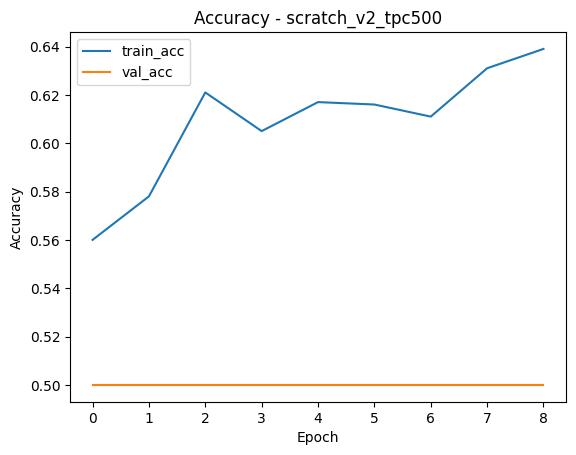

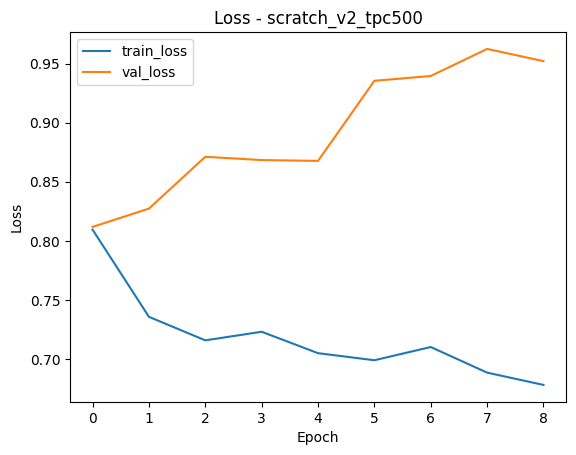

[Cats saved/skipped] train 2000/0, val 250/0, test 250/0
[Dogs saved/skipped] train 2000/0, val 250/0, test 250/0
[Final counts] train: Cat=2000, Dog=2000 | val: Cat=250, Dog=250 | test: Cat=250, Dog=250
Found 4000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 302ms/step - accuracy: 0.5767 - loss: 0.8040 - val_accuracy: 0.5000 - val_loss: 0.8317 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 301ms/step - accuracy: 0.5917 - loss: 0.7274 - val_accuracy: 0.5020 - val_loss: 0.7778 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 303ms/step - accuracy: 0.6185 - loss: 0.7132 - val_accuracy: 0.5640 - val_loss: 0.7311 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 302ms/step - accuracy: 0.6246 - loss: 0.6985 - val_accuracy: 0.5840 - val_loss: 0.7169 - learning_rate: 0.0010
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 303ms/step 

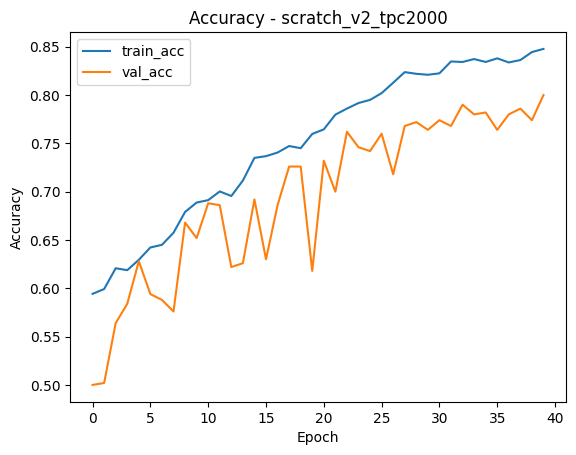

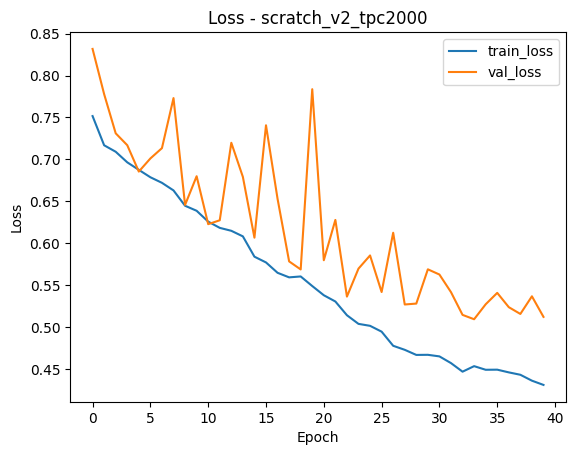

[Cats saved/skipped] train 4000/0, val 250/0, test 250/0
[Dogs saved/skipped] train 4000/0, val 250/0, test 250/0
[Final counts] train: Cat=4000, Dog=4000 | val: Cat=250, Dog=250 | test: Cat=250, Dog=250
Found 8000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 92s 301ms/step - accuracy: 0.5730 - loss: 0.7765 - val_accuracy: 0.5360 - val_loss: 0.7392 - learning_rate: 0.0010
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 300ms/step - accuracy: 0.6297 - loss: 0.7025 - val_accuracy: 0.5660 - val_loss: 0.7317 - learning_rate: 0.0010
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 298ms/step - accuracy: 0.6394 - loss: 0.6836 - val_accuracy: 0.5260 - val_loss: 0.7778 - learning_rate: 0.0010
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 299ms/step - accuracy: 0.6615 - loss: 0.6622 - val_accuracy: 0.7020 - val_loss: 0.6425 - learning_rate: 0.0010
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 299ms/step 

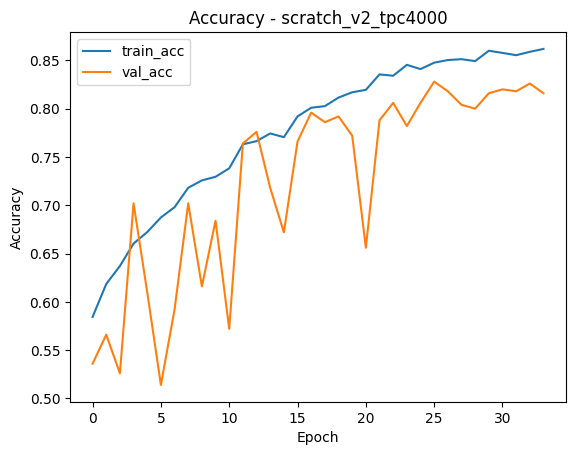

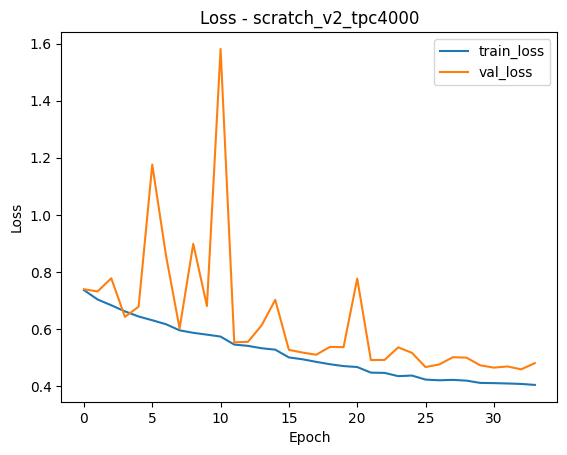

,run,train_per_class,total_train,best_val_acc,test_acc
0,scratch_v2_tpc500,500,1000,0.500,0.500
1,scratch_v2_tpc2000,2000,4000,0.800,0.814
2,scratch_v2_tpc4000,4000,8000,0.828,0.820


In [7]:
VAL_PER_CLASS = 250
TEST_PER_CLASS = 250
TRAIN_SIZES_PER_CLASS = [500, 2000, 4000]   # Step 1, Step 2, Step 3
EPOCHS_SCRATCH = 40

PART_A_RESULTS = []
ROOT = "/content/experiments_scratch_v2"

for tpc in TRAIN_SIZES_PER_CLASS:
    exp_root = f"{ROOT}/train_per_class_{tpc}"
    build_balanced_split(exp_root, train_per_class=tpc,
                         val_per_class=VAL_PER_CLASS, test_per_class=TEST_PER_CLASS)
    train_ds, val_ds, test_ds = make_datasets(exp_root)

    model = make_scratch_model()
    summary = train_and_evaluate(model, train_ds, val_ds, test_ds,
                                 tag=f"scratch_v2_tpc{tpc}", epochs=EPOCHS_SCRATCH)
    summary["train_per_class"] = tpc
    summary["total_train"] = tpc * 2
    PART_A_RESULTS.append(summary)

df_results = pd.DataFrame(PART_A_RESULTS)[
    ["run", "train_per_class", "total_train", "best_val_acc", "test_acc"]
].sort_values("train_per_class").reset_index(drop=True)
df_results


In [8]:
csv_path = "/content/dogs_vs_cats_scratch_results_v2.csv"
df_results.to_csv(csv_path, index=False)
print("Saved:", csv_path)


Saved: /content/dogs_vs_cats_scratch_results_v2.csv
